In [125]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from torchvision import *
from torchvision.models import vgg16_bn
from fastai.vision.gan import *
import os

In [58]:
from PIL import Image, ImageDraw, ImageFont

In [118]:
gc.collect()

24204

In [119]:
torch.cuda.empty_cache()

In [120]:
os.environ['FASTAI_TB_CLEAR_FRAMES']="0"

In [121]:
torch.cuda.set_device(0)
torch.cuda.empty_cache()

In [7]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

# note: this notebook relies on models created by lesson7-superres.ipynb
# path_pets = untar_data(URLs.PETS)

In [8]:
defaults.cpus=1

In [9]:
il = ImageList.from_folder(path_hr)
il

ImageList (7390 items)
Image (3, 400, 600),Image (3, 500, 375),Image (3, 500, 394),Image (3, 313, 450),Image (3, 465, 500)
Path: C:\Users\bokhy\.fastai\data\oxford-iiit-pet\images

In [9]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [10]:
bs,size=16,128

arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [11]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.relative_to(path_lr))
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True)) 
    # ImageNet_stats = True because we're going to use a pre-trained model in next learner 

    data.c = 3
    return data

In [12]:
data = get_data(bs,size)

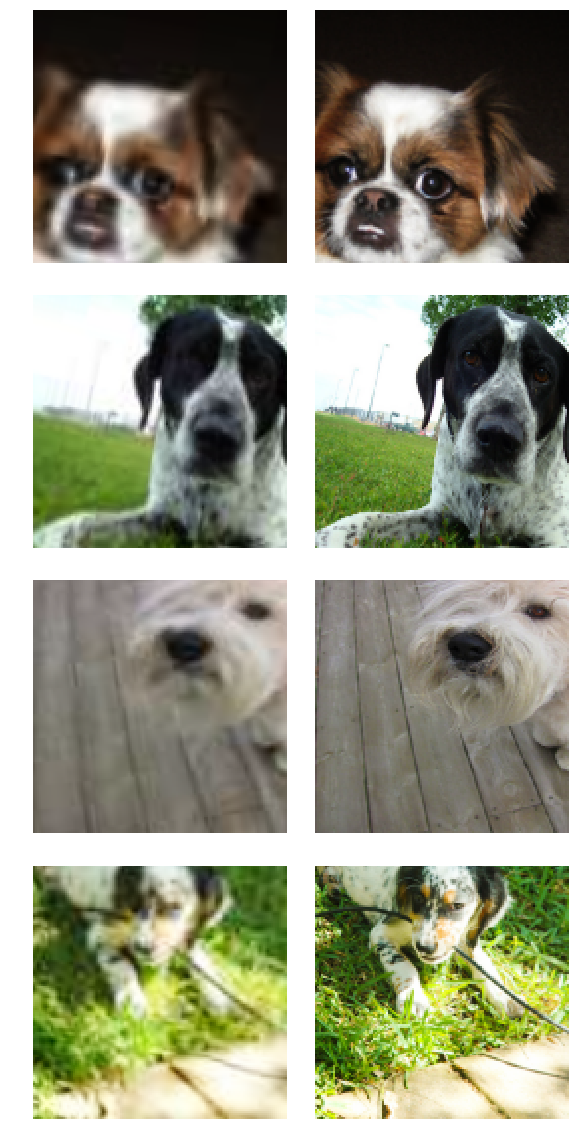

In [15]:
# Crappy images and original images
data.show_batch(4)

## 1. Create a Generator

In [13]:
wd = 1e-3

In [13]:
y_range = (-3.,3.)

In [14]:
loss_gen = MSELossFlat()
# It's mean squared error between the actual pixel value and the pixel value that we predicted

In [15]:
def create_gen_learner():
    return unet_learner(data, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [19]:
learn_gen = create_gen_learner()

In [25]:
learn_gen.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


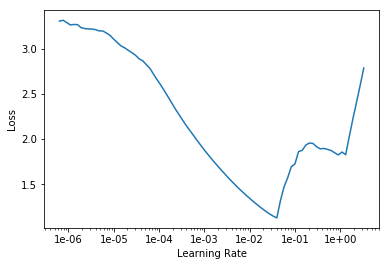

In [26]:
learn_gen.recorder.plot()

In [33]:
learn_gen.fit_one_cycle(3, 1e-03)

In [ ]:
learn_gen.fit(3, 1e-03)

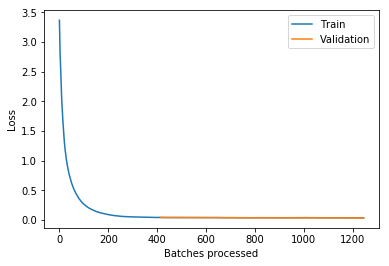

In [32]:
learn_gen.recorder.plot_losses()

In [41]:
learn_gen.unfreeze()

In [42]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

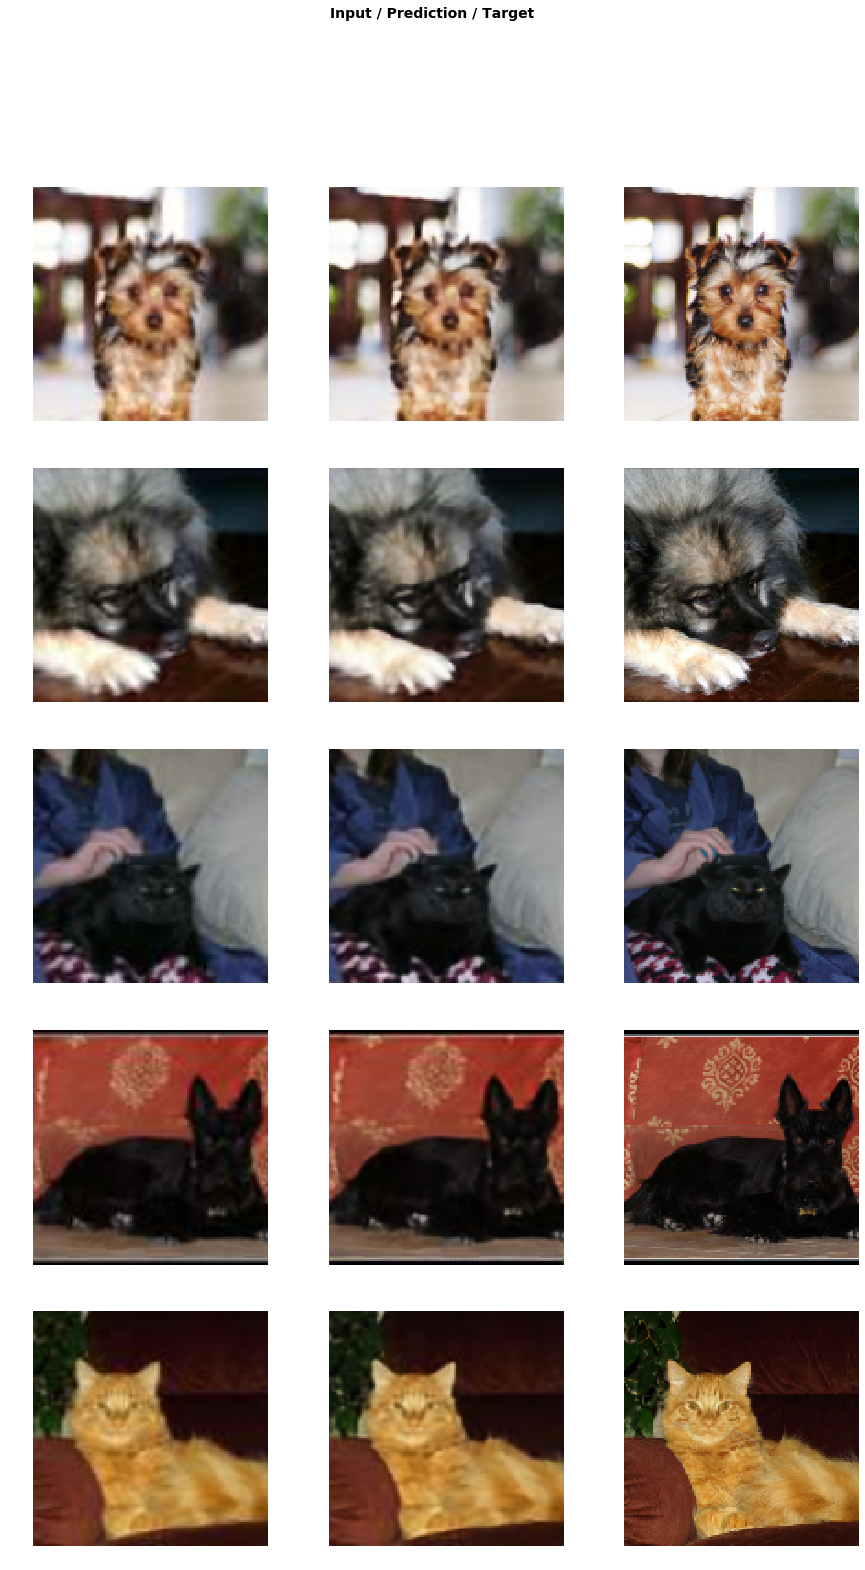

In [34]:
learn_gen.show_results(rows=5,imgsize=5)

In [35]:
learn_gen.save('gen-pre2',return_path=True)

WindowsPath('C:/Users/bokhy/.fastai/data/oxford-iiit-pet/small-96/models/gen-pre2.pth')

In [71]:
learn_gen.path

WindowsPath('C:/Users/bokhy/.fastai/data/oxford-iiit-pet/small-96')

In [36]:
learn_gen.export('gen-pre2.pkl')

## 2. Create a Critic (discriminator)

In [ ]:
# 2.1
# To create just a totally standard fast.ai binary classification model, we need two folders; 
# one folder containing high-res images, one folder containing generated images. 
# We already have the folder with high-res images, so we just have to save our generated images.

In [24]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [46]:
path_gen.mkdir(exist_ok=True)

In [47]:
# Let's create and save save generated images
# We're going to grab all of the file names. 
# So here's the file names in that data loader's dataset. 
# Now let's go through each batch of the data loader, and let's grab a batch of predictions for that batch, 
# and then reconstruct=True means it's  going to create fast.ai image-objects for each thing in the batch
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [48]:
save_preds(data.fix_dl)

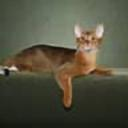

In [49]:
PIL.Image.open(path_gen.ls()[0])

In [22]:
# Train a Critic
# Pretrain the critic on crappy vs not crappy
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [25]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

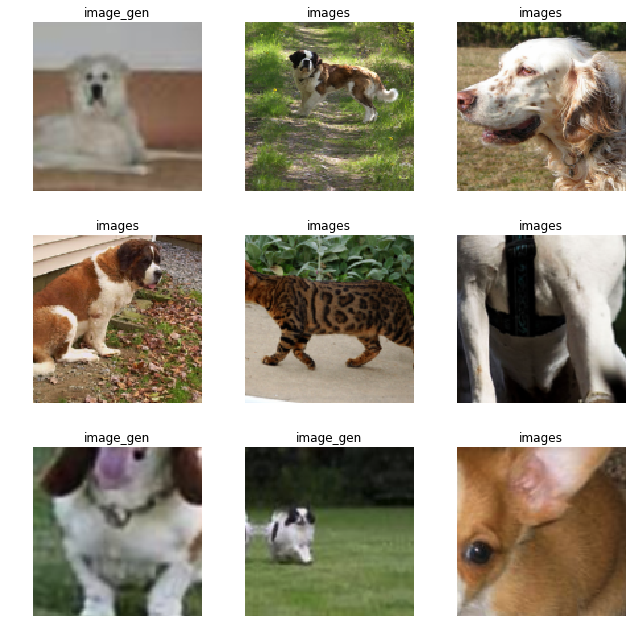

In [53]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [ ]:
# binary cross entropy as usual. However, we're not going to use a ResNet here. 
# The reason is when you're doing a GAN, you need to be particularly careful that the generator and the critic can't both push in the same direction and increase the weights out of control. 
# So we have to use something called spectral normalization to make GANs work nowadays
# This can be done using 

In [10]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [11]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [56]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)
learn_critic

Learner(data=ImageDataBunch;

Train: LabelList (12637 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
images,images,images,images,images
Path: C:\Users\bokhy\.fastai\data\oxford-iiit-pet;

Valid: LabelList (1404 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
image_gen,image_gen,image_gen,images,image_gen
Path: C:\Users\bokhy\.fastai\data\oxford-iiit-pet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Dropout2d(p=0.075, inplace=False)
  (2): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (1): Sequential(
    

In [66]:
learn_critic.fit_one_cycle(5, 1e-3)

In [67]:
learn_critic.save('critic-pre2',return_path=True)

WindowsPath('C:/Users/bokhy/.fastai/data/oxford-iiit-pet/models/critic-pre2.pth')

In [68]:
learn_critic.export('critic-pre2.pkl')

# 3. Conbine Generator and Critic to create GAN model 

In [ ]:
# Now that we have a pre-trained  generator and  critic, 
# we now need to get it to kind of ping pong between training a little bit of each

In [30]:
learn_crit=None
learn_gen=None
gc.collect()

80

In [31]:
# we have to specify the learner objects for the generator and the critic

In [32]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')
# The loss of the critic is given by learn_crit.loss_func. 
# We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0).

In [84]:
learn_crit.purge() 

c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LeakyReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dro

Learner(data=ImageDataBunch;

Train: LabelList (12637 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
images,images,images,images,images
Path: C:\Users\bokhy\.fastai\data\oxford-iiit-pet;

Valid: LabelList (1404 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
image_gen,image_gen,image_gen,images,image_gen
Path: C:\Users\bokhy\.fastai\data\oxford-iiit-pet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Dropout2d(p=0.075, inplace=False)
  (2): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (1): Sequential(
    

In [33]:
learn_gen = create_gen_learner().load('gen-pre2')
# The loss of the generator is weighted sum (weights in weights_gen) of learn_crit.loss_func 
# on the batch of fake (passed throught the critic to become predictions) with a target of 1, 
# and the learn_gen.loss_func applied to the output (batch of fake) and the target (corresponding batch of superres images).

NameError: name 'data' is not defined

In [86]:
learn_gen.purge() 

c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\bokhy\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type R

Learner(data=ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: C:\Users\bokhy\.fastai\data\oxford-iiit-pet\small-96;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: C:\Users\bokhy\.fastai\data\oxford-iiit-pet\small-96;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride

In [ ]:
# Pass in your generator and your critic to GAN Learner 
# and it will go ahead and when you go learn.fit, it'll figure out how much time to train generator and then when to switch to training the discriminator/critic and it'll go backward and forward.

In [ ]:
# These weights here (weights_gen=(1.,50.)) 
#  add together the pixel loss and the critic loss. Those two losses on different scales, 
# so we multiplied the pixel loss by something between about 50 and about 200 - something in that range generally works pretty well.

In [12]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
# Just use these hyper parameters
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

NameError: name 'learn_gen' is not defined

In [111]:
learn

GANLearner(data=ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: C:\Users\bokhy\.fastai\data\oxford-iiit-pet\small-96;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: C:\Users\bokhy\.fastai\data\oxford-iiit-pet\small-96;

Test: None, model=GANModule(
  (generator): DynamicUnet(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
   

In [ ]:
# The loss here does not mean anything
# But the numbers should stay about the same.
# So that's one of the tough things about training GANs is it's hard to know how are they doing. 
# The only way to know how are they doing is to actually take a look at the results from time to time.

In [146]:
learn.fit_one_cycle(1,1e-4)
# chose 40 or more in ideal

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 4.00 GiB total capacity; 2.85 GiB already allocated; 486.40 KiB free; 85.95 MiB cached)

In [ ]:
# update data of the learner
learn.data=get_data(16,192)

In [ ]:
learn.fit(10,1e-4/2)

In [ ]:
learn.show_results(rows=16)

In [ ]:
learn.save('gan',return_path=True)

In [ ]:
learn.export('a.pkl')

# Improve the result using custom feature loss

In [14]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [15]:
# It will most likely be L1 loss (or MSE)
base_loss = F.l1_loss

In [16]:
# Let's create a VGG model - just using the pre-trained model. 
# In VGG, there's a attribute called (.features) which contains the convolutional part of the model. 
# So "vgg16_bn(True)" is the convolutional part of the VGG model. 
# Because we don't need the head. We only want the intermediate activations.
# we'll put it into eval mode because we're not training it.
# we'll turn off requires_grad because we don't want to update the weights of this model
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [17]:
# Then let's enumerate through all the children of that model and find all of the max pooling layers, 
# because in the VGG model that's where the grid size changes
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

### Feature Loss function

In [18]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [19]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])
# FeatureLoss(m_feat, layer_ids, layer_wgts)

In [20]:
feat_loss

FeatureLoss(
  (m_feat): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(12

In [28]:
# Now we can just go ahead and train a U-Net in the usual way with 
# data= our data 
# arch= pre-trained architecture which is a ResNet 34, 
# wd = weight decay
# loss_func = loss function which is using our pre trained VGG model. 
# This (callback_fns) is that callback I mentioned LossMetrics which is going to print out all the different layers losses for us. 
# These are two things (blur and norm_type) Just use them!!

In [21]:
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight)

In [184]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 100.00 MiB (GPU 0; 4.00 GiB total capacity; 2.59 GiB already allocated; 74.47 MiB free; 271.07 MiB cached)

In [ ]:
learn.recorder.plot()

In [40]:
lr = 1e-3

In [27]:
learn.fit_one_cycle(4, lr)

WindowsPath('C:/Users/bokhy/.fastai/data/oxford-iiit-pet/small-96/models/1a.pth')

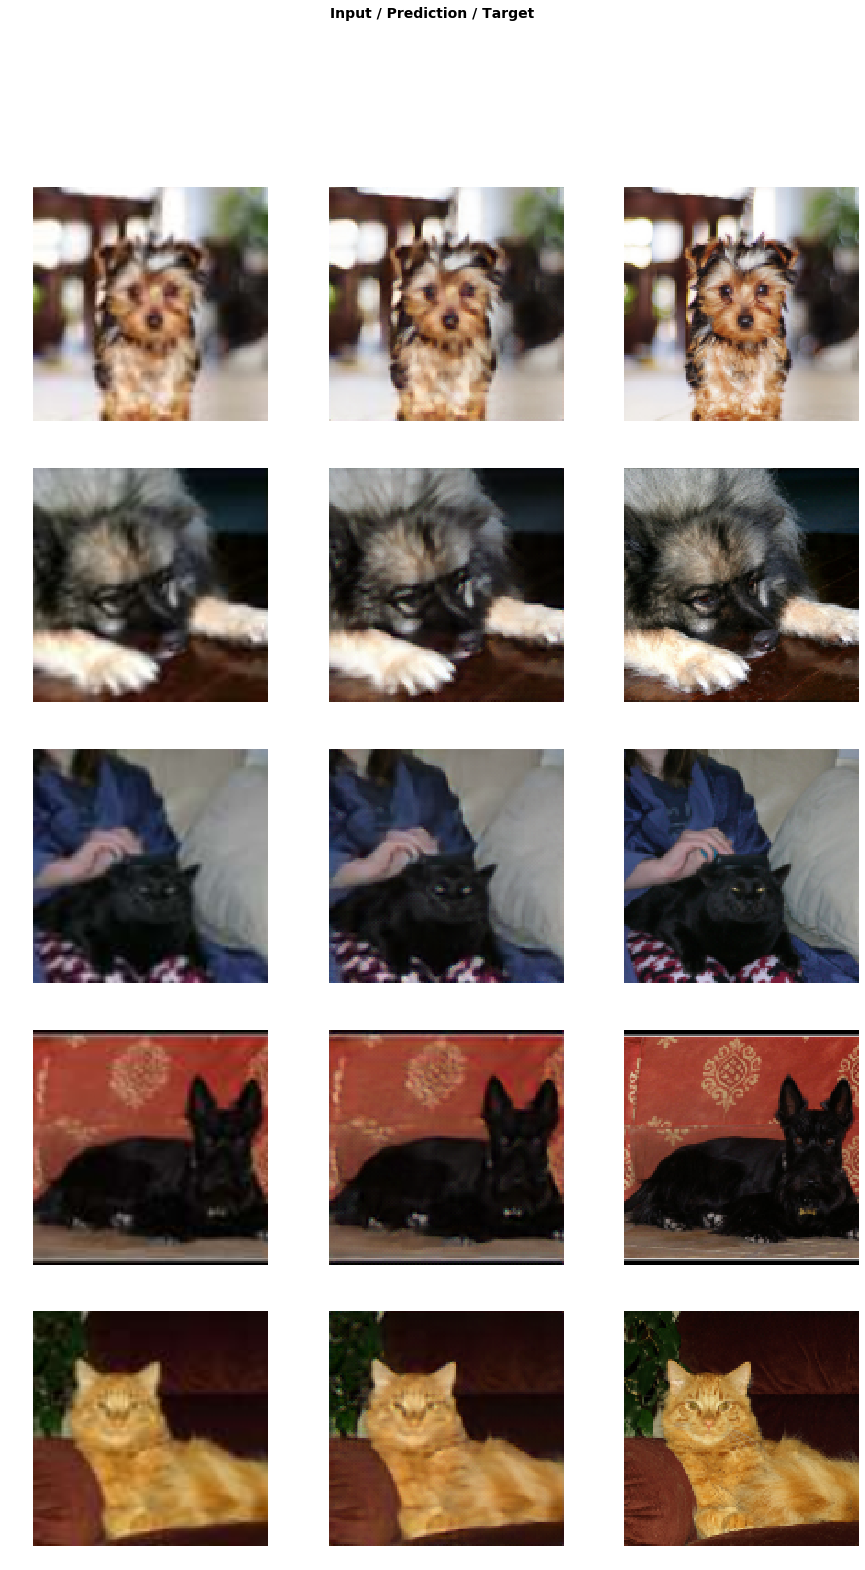

In [30]:
learn.show_results(rows=5, imgsize=5)
learn.save('1a',return_path=True)

In [41]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-5,lr))

WindowsPath('C:/Users/bokhy/.fastai/data/oxford-iiit-pet/small-96/models/1b.pth')

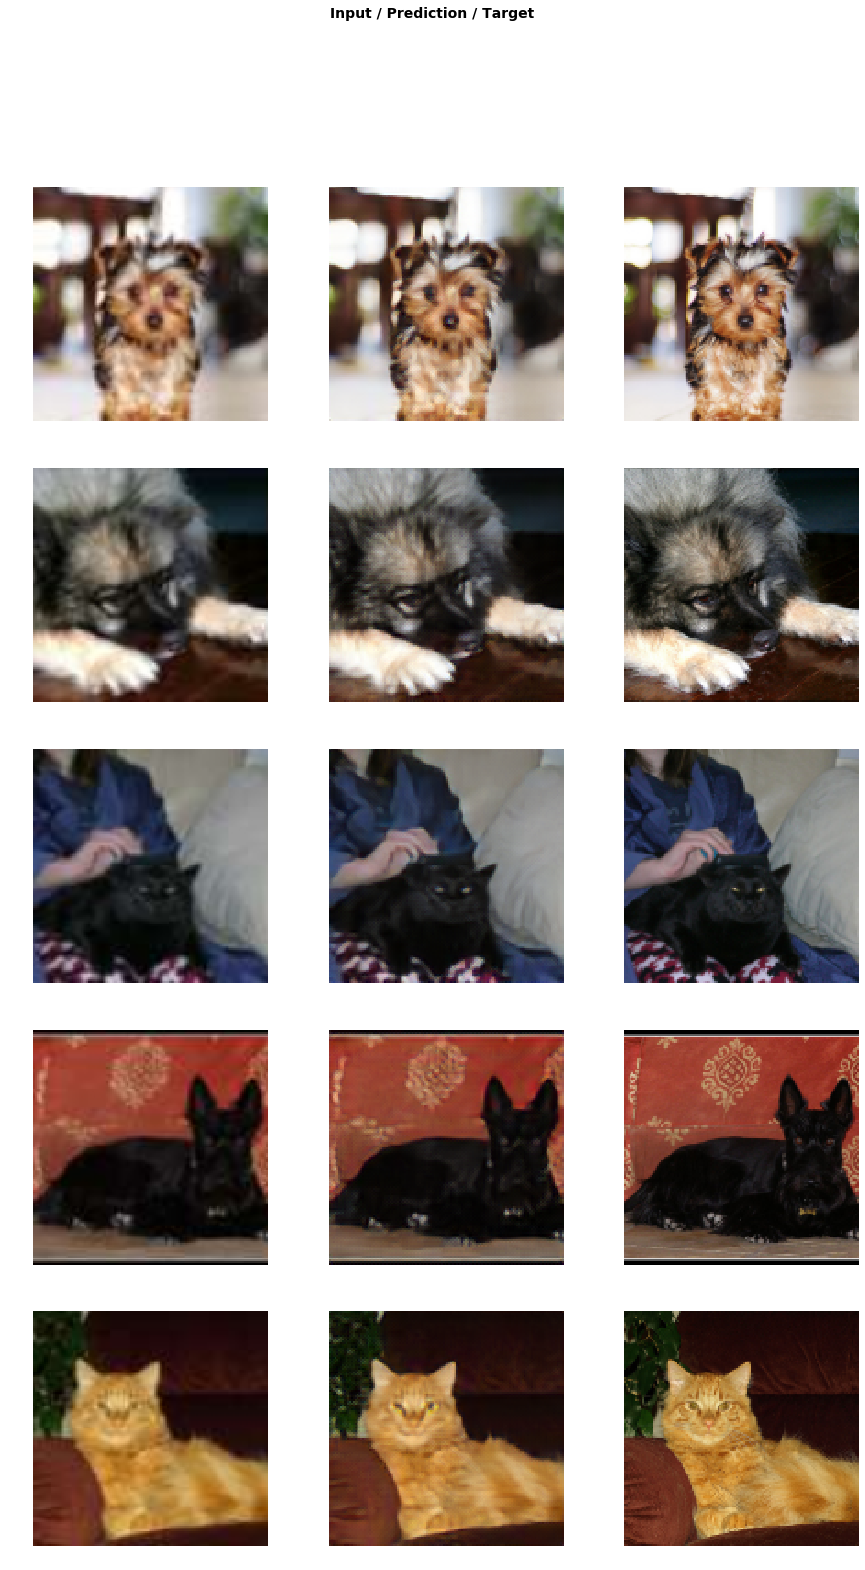

In [42]:
learn.show_results(rows=5, imgsize=5)
learn.save('1b',return_path=True)

In [ ]:
# Then let's switch up to double the size. 
# So we need to also halve the batch size to avoid running out of GPU memory, and freeze again, and train some more.

In [26]:
data = get_data(8,size*2)

In [27]:
learn.data = data
learn.freeze()
gc.collect()

20

In [28]:
learn.load('1b');

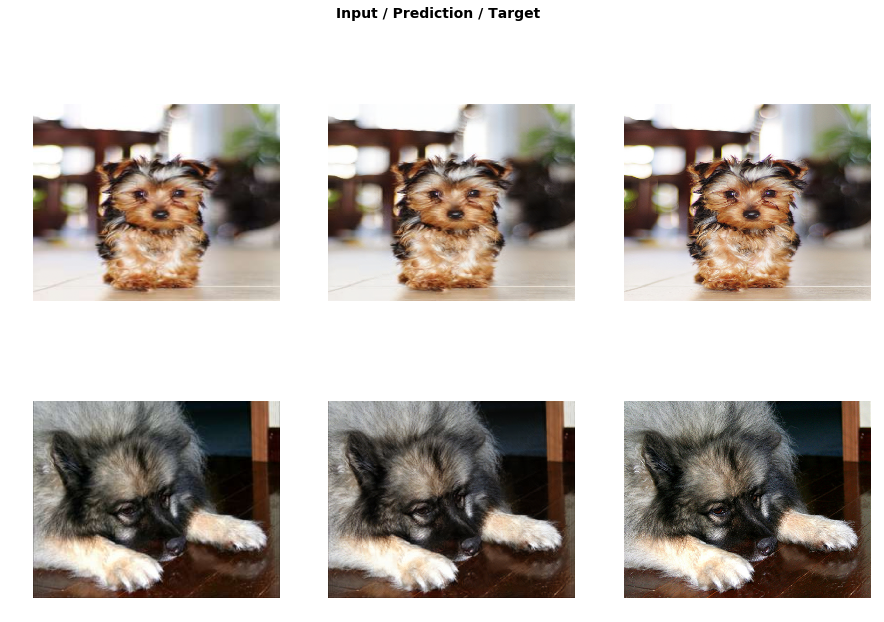

In [78]:
learn.show_results(rows=5,imgsize=5)

In [39]:
learn.fit_one_cycle(5, 1e-3)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.93 GiB already allocated; 12.47 MiB free; 22.27 MiB cached)

In [ ]:
learn.show_results(rows=5,imgsize=5)
learn.save('1c',return_path=True)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-6,1e-3), pct_start=0.3)

In [ ]:
learn.show_results(rows=5,imgsize=5)
# If you create your own crappification functions and train this model, you'll' build stuff that nobody's built before.

In [ ]:
learn.recorder.plot_losses()

In [1]:
learn.save('GAN-final',return_path=True)

NameError: name 'learn' is not defined

In [ ]:
learn.export('GAN-final.pkl')

# Test the Model using Testset (or Test images)

In [ ]:
learn = None

In [40]:
_=learn.load('1b')

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.94 GiB already allocated; 6.47 MiB free; 14.96 MiB cached)

In [41]:
# medium resolution?
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.relative_to(path_mr))
          .transform(get_transforms(), size=(820,1024), tfm_y=True)
          .databunch(bs=2).normalize(imagenet_stats, do_y=True))

In [42]:
learn.data = data_mr

In [101]:
############################
# here put some image you want to enhance
fn = data_mr.valid_ds.x.items[1]; fn
# fn = path_pets/'other'/'dropout.jpg'
############################

WindowsPath('C:/Users/bokhy/.fastai/data/oxford-iiit-pet/small-256/keeshond_147.jpg')

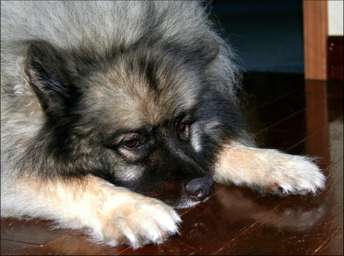

In [102]:
# look at image shape
img = open_image(fn); img.shape; img

In [122]:
# predict
p,img_hr,b = learn.predict(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


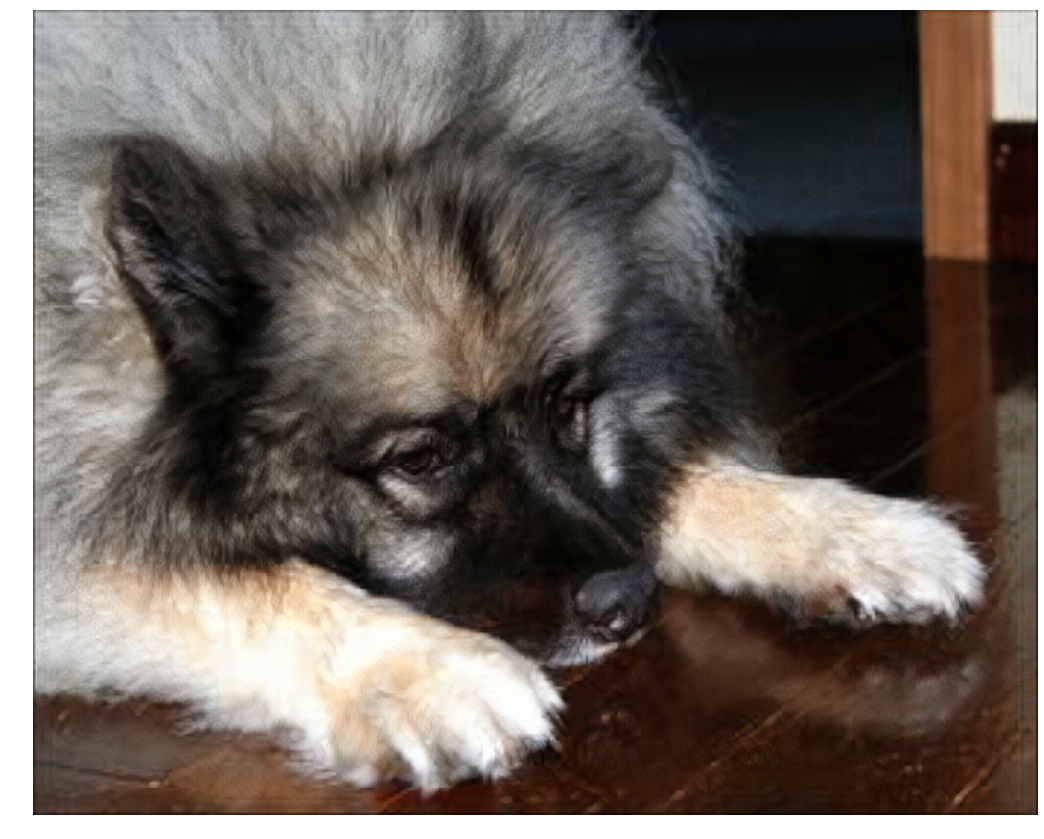

In [110]:
# original data
show_image(img_hr, figsize=(18,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


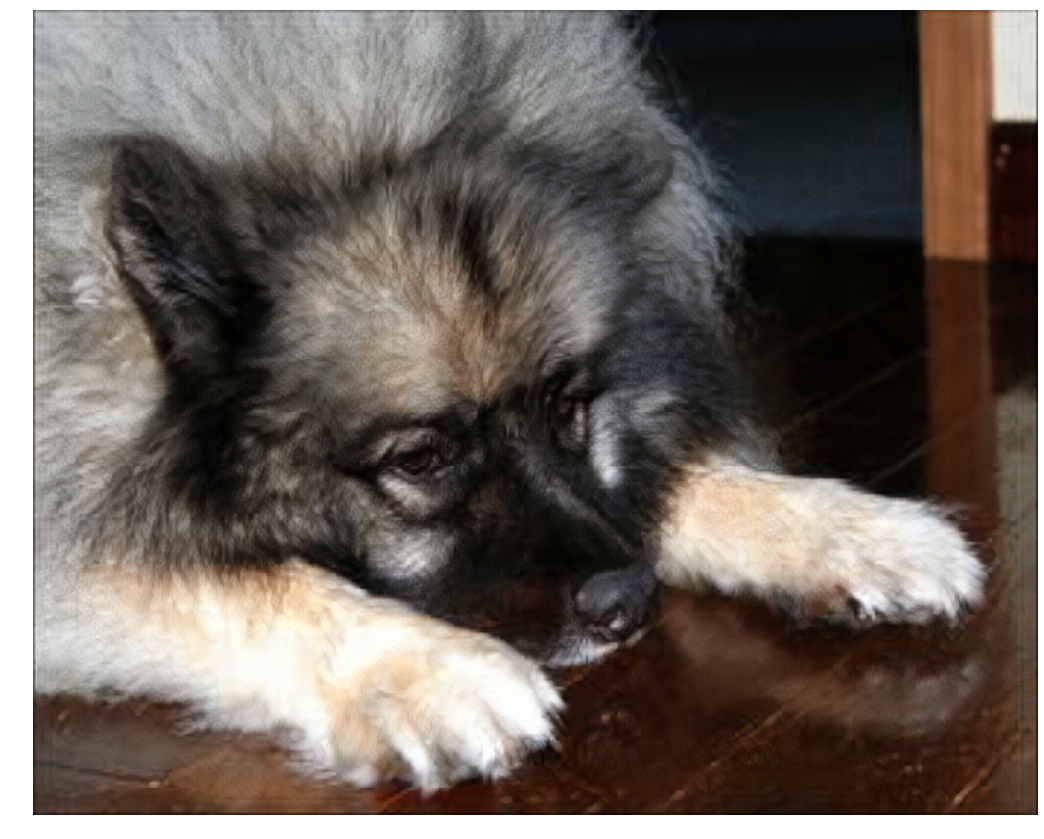

In [126]:
# Enhanced data
!pip install Pillow==6.0.0
Image(img_hr).show(figsize=(18,15))